In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import seaborn as sns
from Bio import SeqIO, Seq

import glob, os, yaml, subprocess, itertools, sparse, sys
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
# from statsmodels.distributions.empirical_distribution import ECDF
import sklearn.metrics
from sklearn.decomposition import PCA
import timeit
import scipy.stats as st
import pickle, yaml, tracemalloc
from scipy.stats import binomtest
import statsmodels.api as sm

# eigenvec_df = pd.read_csv("data/eigenvec_100PC.csv").set_index("sample_id")
pca_explained_var = np.load("data/pca_explained_var.npy")
who_variants_combined = pd.read_csv("analysis/who_confidence_2021.csv")

sample_ids_mapping = pd.read_csv("data/sample_ids_mapping.csv")
samples_summary = pd.read_csv("data/samples_summary.csv")
drug_CC = pd.read_csv("data/drug_CC.csv")
overview_MIC_data_dict = pd.read_excel("data/overview_MIC_data.xlsx", sheet_name=None)
analysis_dir = '/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue'
input_data_dir = '/n/data1/hms/dbmi/farhat/ye12/who'
drug_gene_mapping = pd.read_csv("data/drug_gene_mapping.csv")

who_variants_combined = pd.read_csv("analysis/who_confidence_2021.csv")

# utils files are in the utils_files folder
sys.path.append("utils")
from data_utils import *
from stats_utils import *

lineages = pd.read_csv("data/lineages.csv", low_memory=False)
import warnings
warnings.filterwarnings("ignore")

# INH Compensatory and Neutral Mutation Controls

In [178]:
inh_results = pd.read_excel("results/BINARY/Isoniazid.xlsx", sheet_name=None)

In [179]:
compens_lst = ['c.-47_-46insT', 'c.-48G>A', 'c.-51G>A', 'c.-81C>T', 'c.-76T>A', 'c.-57C>T', 'c.-52C>T', 'c.-88_-87insAT', 'c.-77T>G', 'c.-72C>T', 'c.-54C>T', 'c.-74G>A', 'c.-52C>A']
compens_lst = ["ahpC_" + val for val in compens_lst]

# 'c.-42T>C' not in dataset, but 'c.-42T>G' is
neutral_lst = ['c.-88G>A', 'c.-84T>C', 'c.-42T>C', 'c.-42T>G', 'c.-88G>A', 'c.-46G>A', 'c.-10G>A', 'c.33G>A']
neutral_lst = ["ahpC_" + val for val in neutral_lst]

print(len(compens_lst), len(neutral_lst))

13 8


In [222]:
inh_tier1_WHO = inh_results["Model_3"].loc[~pd.isnull(inh_results["Model_3"]["Odds_Ratio"])]

# add neutral p-value, which is 1 - LRT p-value, then add FDR correction
inh_tier1_WHO["neutral_pval"] = 1 - inh_tier1_WHO["LRT_pval"]
_, bh_pvals, _, _ = sm.multipletests(inh_tier1_WHO["neutral_pval"], method='fdr_bh', is_sorted=False, returnsorted=False)
inh_tier1_WHO["neutral_BH_pval"] = bh_pvals

In [223]:
inh_tier1_WHO.query("mutation.isin(@compens_lst)")["regression_confidence"].value_counts()

Assoc w R - strict        5
Assoc w R                 5
Evidence against Assoc    3
Name: regression_confidence, dtype: int64

In [224]:
# should all be > 0.05
np.min(inh_tier1_WHO.query("mutation.isin(@compens_lst)")["neutral_BH_pval"].values)

0.42197873907259376

In [229]:
# inh_tier1_WHO.query("mutation.isin(@compens_lst)").sort_values("mutation")[["mutation", "position", "confidence_V1", "Odds_Ratio", "OR_LB", "OR_UB", "BH_pval", "PPV_LB", "Num_Isolates", "LRT_BH_pval", "regression_confidence"]]

In [228]:
# ahpC_c.-42T>G, ahpC_c.-88G>A are neutral
inh_tier1_WHO.query("mutation.isin(@neutral_lst)")

,mutation,Tier,predicted_effect,position,confidence_V1,Odds_Ratio,OR_LB,OR_UB,pval,BH_pval,...,LR+_UB,LR-_LB,LR-_UB,regression_confidence,High_Predictive_Value,Phenos,pool_type,synonymous,neutral_pval,neutral_BH_pval
668,ahpC_c.-42T>G,1.0,upstream_gene_variant,2726151,3) Uncertain significance,1.007639,1.000000,1.015626,0.384,0.562238,...,inf,0.999779,1.000072,Evidence against Assoc,0.0,WHO,unpooled,0.0,0.000000,0.000000
1171,ahpC_c.-84T>C,1.0,upstream_gene_variant,2726109,3) Uncertain significance,0.985015,0.975616,1.000000,0.389,0.562238,...,inf,0.999777,1.000036,Evidence against Assoc,0.0,WHO,unpooled,0.0,0.251235,0.466840
1210,ahpC_c.-10G>A,1.0,upstream_gene_variant,2726183,NaN,0.983347,0.973404,1.000000,0.386,0.562238,...,inf,0.999777,1.000036,Evidence against Assoc,0.0,WHO,unpooled,0.0,0.272452,0.482722
1334,ahpC_c.-88G>A,1.0,upstream_gene_variant,2726105,5) Not assoc w R,0.952190,0.883199,1.024105,0.084,0.288857,...,2.19076,0.910376,0.923906,Evidence against Assoc,0.0,WHO,unpooled,0.0,0.000000,0.000000


In [226]:
inh_tier1_WHO.query("mutation.isin(@neutral_lst)")["regression_confidence"].value_counts()

Evidence against Assoc    4
Name: regression_confidence, dtype: int64

In [227]:
inh_tier1_WHO.query("neutral_BH_pval < 0.05").regression_confidence.value_counts()

Evidence against Assoc    123
Assoc w R                   3
Name: regression_confidence, dtype: int64

In [209]:
# weird: all 3 mutations are ONLY present in sample 173060
inh_tier1_WHO.query("neutral_BH_pval < 0.05 & regression_confidence=='Assoc w R'")[['mutation', 'Tier', 'predicted_effect', 'position',
       'Odds_Ratio', 'OR_LB', 'OR_UB', 'pval', 'BH_pval', 'LRT_pval',
       'LRT_BH_pval', 'AUC_pval', 'AUC_BH_pval', 'Num_Isolates',
       'Total_Isolates', 'TP', 'FP', 'TN', 'FN', 'PPV', 'NPV']]

,mutation,Tier,predicted_effect,position,Odds_Ratio,OR_LB,OR_UB,pval,BH_pval,LRT_pval,...,AUC_pval,AUC_BH_pval,Num_Isolates,Total_Isolates,TP,FP,TN,FN,PPV,NPV
513,katG_p.Val628Gly,1.0,missense_variant,2154229,1.013315,1.0,1.023394,0.0,0.0,1.0,...,NaN,NaN,1.0,34814.0,1.0,0.0,21433.0,13380.0,1.0,0.615661
514,katG_c.-506A>T,1.0,upstream_gene_variant,2156617,1.013315,1.0,1.023394,0.0,0.0,1.0,...,NaN,NaN,1.0,34814.0,1.0,0.0,21433.0,13380.0,1.0,0.615661
515,katG_p.Ala492Val,1.0,missense_variant,2154637,1.013315,1.0,1.023394,0.0,0.0,1.0,...,NaN,NaN,1.0,34814.0,1.0,0.0,21433.0,13380.0,1.0,0.615661


In [211]:
model_matrix = pd.read_pickle(os.path.join(analysis_dir, "Isoniazid/BINARY/tiers=1/phenos=WHO/dropAF_noSyn_unpooled/model_matrix.pkl"))

In [215]:
model_matrix[["katG_p.Val628Gly", "katG_c.-506A>T", "katG_p.Ala492Val"]].sum()

mutation
katG_p.Val628Gly    1.0
katG_c.-506A>T      1.0
katG_p.Ala492Val    1.0
dtype: float64

In [218]:
model_matrix.loc[model_matrix["katG_p.Ala492Val"]==1]

mutation,ahpC_c.-10G>A,ahpC_c.-34delA,ahpC_c.-36C>T,ahpC_c.-3G>C,ahpC_c.-3_-2insT,ahpC_c.-40G>A,ahpC_c.-41C>T,ahpC_c.-42T>G,ahpC_c.-44_-43insC,ahpC_c.-45A>G,...,katG_p.Val710Gly,katG_p.Val710Ile,katG_p.Val731Gly,katG_p.Val731Met,katG_p.Val739Met,katG_p.Val73Ala,katG_p.Val73Gly,katG_p.Val83Gly,katG_p.Val83Leu,katG_p.Val83fs
sample_id,,,,,,,,,,,,,,,,,,,,,
173060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [217]:
model_matrix.loc[model_matrix["katG_c.-506A>T"]==1]

mutation,ahpC_c.-10G>A,ahpC_c.-34delA,ahpC_c.-36C>T,ahpC_c.-3G>C,ahpC_c.-3_-2insT,ahpC_c.-40G>A,ahpC_c.-41C>T,ahpC_c.-42T>G,ahpC_c.-44_-43insC,ahpC_c.-45A>G,...,katG_p.Val710Gly,katG_p.Val710Ile,katG_p.Val731Gly,katG_p.Val731Met,katG_p.Val739Met,katG_p.Val73Ala,katG_p.Val73Gly,katG_p.Val83Gly,katG_p.Val83Leu,katG_p.Val83fs
sample_id,,,,,,,,,,,,,,,,,,,,,
173060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [216]:
model_matrix.loc[model_matrix["katG_p.Val628Gly"]==1]

mutation,ahpC_c.-10G>A,ahpC_c.-34delA,ahpC_c.-36C>T,ahpC_c.-3G>C,ahpC_c.-3_-2insT,ahpC_c.-40G>A,ahpC_c.-41C>T,ahpC_c.-42T>G,ahpC_c.-44_-43insC,ahpC_c.-45A>G,...,katG_p.Val710Gly,katG_p.Val710Ile,katG_p.Val731Gly,katG_p.Val731Met,katG_p.Val739Met,katG_p.Val73Ala,katG_p.Val73Gly,katG_p.Val83Gly,katG_p.Val83Leu,katG_p.Val83fs
sample_id,,,,,,,,,,,,,,,,,,,,,
173060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Create Combined Lineages File

In [65]:
def combine_lineages_with_sampleIDs(lineages_fName, sample_ids_mapping):
    
    lineages_df = pd.read_csv(lineages_fName, low_memory=False)
    lineages_df["Sample Name"] = [name.split("-")[0] for name in lineages_df["File_Name"]]
    lineages_df = lineages_df.merge(sample_ids_mapping, on="Sample Name", how="inner")

    lineages_df = lineages_df.dropna(axis=1, how="all").reset_index(drop=True)
    lineages_df = lineages_df[lineages_df.columns[~lineages_df.columns.str.startswith("Count")]]
    
    # remove count strings from the original Lineage field
    for i, row in lineages_df.iterrows():
    
        lineage = row["Lineage"]

        if type(lineage) == str:
            remove_start_idx = list(lineage).index("(")
            lineages_df.loc[i, "Lineage"] = lineage[:remove_start_idx]
        
    # the null ones are all some combination of canetti, westafrican, ethiopian, tur, mungi. There are only ~10-15 of these, so drop
    # null means it couldn't e classified in the Coll 2014 scheme, but other columns are not null because a different scheme classified them
    lineages_df = lineages_df.loc[~pd.isnull(lineages_df["Lineage_1"])]
    
    # multiple directories contain the same VCF files, so drop duplicates here
    lineages_df = lineages_df.sort_values("Lineage", ascending=True).drop_duplicates(subset=["Sample Name", "Sample ID", "Lineage"], keep="first")
    return lineages_df

In [66]:
lineages_df = combine_lineages_with_sampleIDs("data/lineages_2.csv", sample_ids_mapping)
lineages_df.shape

(65786, 12)

In [308]:
# for _, row in lineages_df.loc[pd.isnull(lineages_df["Lineage_1"])].reset_index(drop=True).iterrows():
    
#     fName = row["VCF_Dir"] + "/" + row["File_Name"]

#     proc = subprocess.Popen(f"fast-lineage-caller {fName} --noheader --count --pass", shell=True, encoding='utf8', stdout=subprocess.PIPE)
#     output = proc.communicate()[0]

#     # output order: Isolate, coll2014, freschi2020, lipworth2019, shitikov2017, stucki2016 
#     print(output.split("\t")[3])

# New Lineage Structure Correction

Perhaps we should do a test of univariate association between all PCs individually and the phenotype and select those that have P-value <0.1 or something before including them in the model, as opposed to just including the top n PCs in terms of variance.

In [37]:
coll2014 = pd.read_csv("data/coll2014_SNP_scheme.tsv", sep="\t")
coll2014["#lineage"] = coll2014["#lineage"].str.replace("lineage", "")
coll2014.rename(columns={"#lineage": "Lineage"}, inplace=True)

coll2014.query("Lineage.str.startswith('2.2.1')")

,Lineage,position,allele_change,tag
11,2.2.1,797736,C/T,coll2014
12,2.2.1.1,4248115,C/T,coll2014
13,2.2.1.2,3836274,G/A,coll2014


In [234]:
# minor allele counts dataframe for all samples
minor_allele_counts = pd.read_pickle("data/minor_allele_counts.pkl")

L2_samples = minor_allele_counts.loc[minor_allele_counts[coll2014.set_index("Lineage").loc["2", "position"]]==1].index.values
L221_samples = minor_allele_counts.loc[minor_allele_counts[coll2014.set_index("Lineage").loc["2.2.1", "position"]] == 1].index.values
print(len(L2_samples), len(L221_samples))

16843 15650


In [45]:
model_matrix.query("index in @L221_samples").to_pickle(os.path.join(analysis_dir, "Bedaquiline/BINARY/tiers=1/phenos=WHO/dropAF_noSyn_unpooled/model_matrix_L2.2.1.pkl"))

In [118]:
L221_WHO = pd.read_csv(os.path.join(analysis_dir, "Bedaquiline/BINARY/tiers=1/phenos=WHO/dropAF_noSyn_unpooled/model_analysis_L2.2.1.csv"))

In [120]:
L221_WHO.query("mutation=='mmpS5_c.-74G>T'")

,mutation,coef,coef_LB,coef_UB,pval,neutral_pval,BH_pval,Bonferroni_pval,neutral_BH_pval,neutral_Bonferroni_pval,Odds_Ratio,OR_LB,OR_UB,confidence
3,mmpS5_c.-74G>T,0.540786,0.323041,0.738857,0.0,1.0,0.0,0.0,1.0,1.0,1.717355,1.381321,2.093542,3) Uncertain significance


In [124]:
len(L221_WHO.query("mutation.str.contains('PC')"))

44

In [246]:
pheno_category_lst = ["WHO"]
drug = "Bedaquiline"

if "ALL" in pheno_category_lst:
    model_matrix = pd.read_pickle(os.path.join(analysis_dir, "Bedaquiline/BINARY/tiers=1/phenos=ALL/dropAF_noSyn_unpooled/model_matrix.pkl"))
else:
    model_matrix = pd.read_pickle(os.path.join(analysis_dir, "Bedaquiline/BINARY/tiers=1/phenos=WHO/dropAF_noSyn_unpooled/model_matrix.pkl"))
    
# print(model_matrix.shape)
# df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv")).set_index("sample_id").query("phenotypic_category in @pheno_category_lst")
# eigenvec_df = pd.read_csv("data/eigenvec_20PC.csv").set_index("sample_id")

# # model_matrix = model_matrix.merge(minor_allele_counts, left_index=True, right_index=True)
# model_matrix = model_matrix.merge(eigenvec_df, left_index=True, right_index=True)

# # keep only samples (rows) that are in matrix and use loc with indices to ensure they are in the same order
# df_phenos = df_phenos.loc[model_matrix.index]
# print(df_phenos.shape)

# # check that the sample ordering is the same in the genotype and phenotype matrices
# assert sum(model_matrix.index != df_phenos.index) == 0

In [24]:
L221_BDQ = model_matrix.query("index in @L221_samples")
df_phenos_L221 = df_phenos.loc[L221_BDQ.index]

L2_BDQ = model_matrix.query("index in @L2_samples")
df_phenos_L2 = df_phenos.loc[L2_BDQ.index]

# check that the sample ordering is the same in the genotype and phenotype matrices
assert sum(L221_BDQ.index != df_phenos_L221.index) == 0
assert sum(L2_BDQ.index != df_phenos_L2.index) == 0
print(L221_BDQ.shape, L2_BDQ.shape)

(4817, 641) (5432, 641)


In [25]:
pd.DataFrame(L221_BDQ.merge(df_phenos_L221, left_index=True, right_index=True).groupby(["mmpS5_c.-74G>T", "phenotype"])["phenotype"].count())

phenotype
mmpS5_c.-74G>T phenotype           
0.0            0               4518
               1                168
1.0            0                 94
               1                 37

In [332]:
TP = 36
FP = 3
TN = 550
FN = 118

# probability that an isolate WITH mutation is RESISTANT
print(f"PPV = {np.round(TP / (TP + FP), 2)}")

# probability that an isolate WITHOUT mutation is SUSCEPTIBLE
print(f"NPV = {np.round(TN / (TN + FN), 2)}")

# probability that a RESISTANT isolate HAS the mutation
print(f"Sens = {np.round(TP / (TP + FN), 2)}")

# probability that a SUSCEPTIBLE isolate DOES NOT HAVE the mutation
print(f"Spec = {np.round(TN / (TN + FP), 2)}")

PPV = 0.92
NPV = 0.82
Sens = 0.23
Spec = 0.99


In [333]:
TP = 37
FP = 94
TN = 4518
FN = 168

# probability that an isolate WITH mutation is RESISTANT
print(f"PPV = {np.round(TP / (TP + FP), 2)}")

# probability that an isolate WITHOUT mutation is SUSCEPTIBLE
print(f"NPV = {np.round(TN / (TN + FN), 2)}")

# probability that a RESISTANT isolate HAS the mutation
print(f"Sens = {np.round(TP / (TP + FN), 2)}")

# probability that a SUSCEPTIBLE isolate DOES NOT HAVE the mutation
print(f"Spec = {np.round(TN / (TN + FP), 2)}")

PPV = 0.28
NPV = 0.96
Sens = 0.18
Spec = 0.98


In [27]:
37/(37+94)

0.2824427480916031

# L2.2.1 Phenotype Averages by Variant

In [276]:
phenos_name = "WHO"
model_matrix = pd.read_pickle(os.path.join(analysis_dir, f"Bedaquiline/BINARY/tiers=1/phenos={phenos_name}/dropAF_noSyn_unpooled/model_matrix.pkl"))

df_phenos = pd.read_csv(os.path.join(analysis_dir, "Bedaquiline/phenos_binary.csv"))
df_phenos["L2.2.1"] = df_phenos["sample_id"].isin(L221_samples).astype(int)

df_phenos = df_phenos.merge(model_matrix["mmpS5_c.-74G>T"], left_on="sample_id", right_index=True)

In [292]:
df_phenos.loc[df_phenos["L2.2.1"]==1].groupby("mmpS5_c.-74G>T")["phenotype"].agg(["mean", "count"])

,mean,count
mmpS5_c.-74G>T,,
0.0,0.176647,668
1.0,0.923077,39


In [291]:
pd.DataFrame(df_phenos.loc[df_phenos["L2.2.1"]==1].groupby("mmpS5_c.-74G>T")["phenotype"].value_counts())

phenotype
mmpS5_c.-74G>T phenotype           
0.0            0                550
               1                118
1.0            1                 36
               0                  3

In [282]:
df_phenos.groupby("mmpS5_c.-74G>T")["phenotype"].agg(["mean", "count"])

,mean,count
mmpS5_c.-74G>T,,
0.0,0.406692,2122
1.0,0.923077,39


In [293]:
pd.DataFrame(df_phenos.groupby("mmpS5_c.-74G>T")["phenotype"].value_counts())

phenotype
mmpS5_c.-74G>T phenotype           
0.0            0               1259
               1                863
1.0            1                 36
               0                  3

# L2.2.1 MIC Distribution by Variant

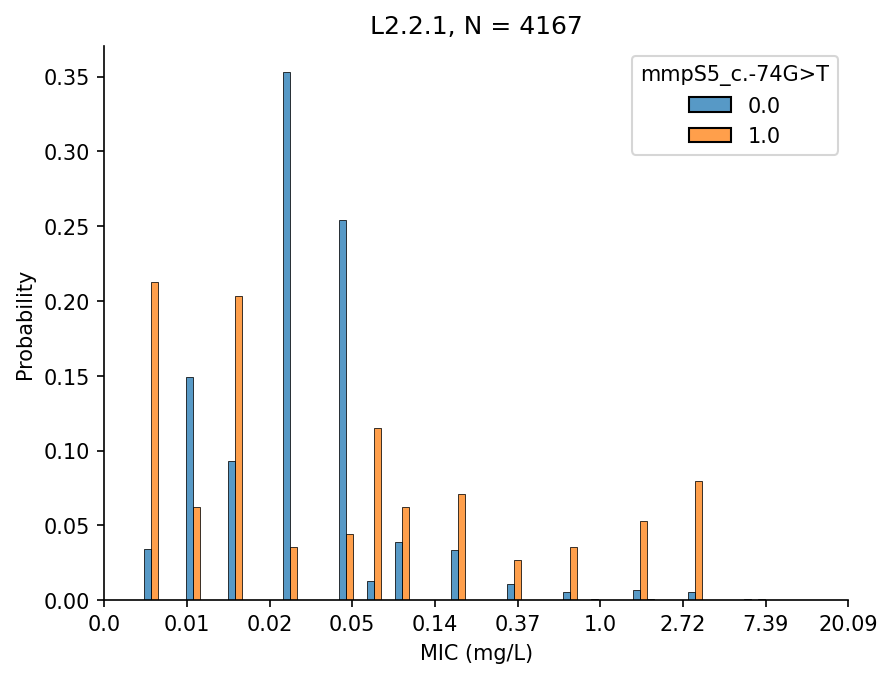

In [273]:
model_matrix = pd.read_pickle(os.path.join(analysis_dir, "Bedaquiline/MIC/tiers=1/dropAF_noSyn_unpooled/model_matrix.pkl"))

df_mic = pd.read_csv(os.path.join(analysis_dir, "Bedaquiline/phenos_mic.csv"))
df_mic = process_multiple_MICs(df_mic)
df_mic["L2.2.1"] = df_mic["sample_id"].isin(L221_samples).astype(int)
df_mic["log-MIC"] = np.log(df_mic["mic_value"])

df_mic = df_mic.merge(model_matrix["mmpS5_c.-74G>T"], left_on="sample_id", right_index=True)

fig, ax = plt.subplots()
sns.histplot(df_mic.loc[df_mic["L2.2.1"]==1], x="log-MIC", hue="mmpS5_c.-74G>T", common_norm=False, multiple="dodge", stat="probability", ax=ax)
plt.title(f"L2.2.1, N = {len(df_mic.loc[df_mic['L2.2.1']==1])}")
ax.set_xticks(ticks=ax.get_xticks(), labels=np.round(np.exp(ax.get_xticks()), 2))
plt.xlabel("MIC (mg/L)")
sns.despine()
plt.show()

In [303]:
# kept 45 out of 100 PCs
L221_MIC_analysis = pd.read_csv("/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Bedaquiline/MIC/tiers=1/dropAF_noSyn_unpooled/model_analysis_L2.2.1.csv")
L221_MIC_analysis.query("mutation=='mmpS5_c.-74G>T'")

,mutation,coef,coef_LB,coef_UB,pval,BH_pval,Bonferroni_pval,confidence
133,mmpS5_c.-74G>T,-0.06225,-0.109089,-0.009317,0.006,0.031778,0.858,3) Uncertain significance


In [294]:
pd.DataFrame(df_mic.groupby("mmpS5_c.-74G>T")["mic_value"].mean())

,mic_value
mmpS5_c.-74G>T,
0.0,0.174464
1.0,0.387504


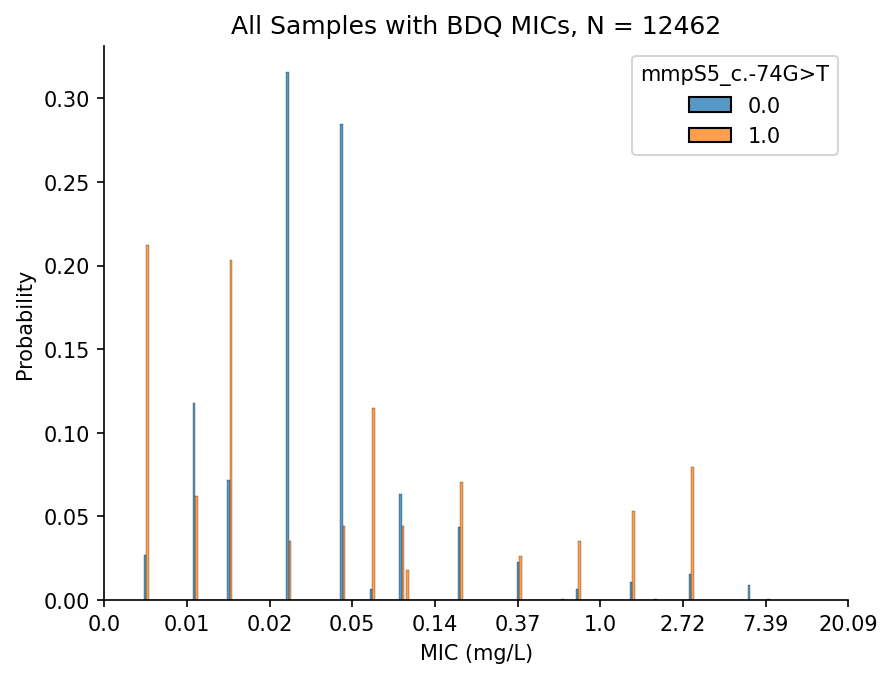

In [296]:
model_matrix = pd.read_pickle(os.path.join(analysis_dir, "Bedaquiline/MIC/tiers=1/dropAF_noSyn_unpooled/model_matrix.pkl"))

df_mic = pd.read_csv(os.path.join(analysis_dir, "Bedaquiline/phenos_mic.csv"))
df_mic = process_multiple_MICs(df_mic)
df_mic["L2.2.1"] = df_mic["sample_id"].isin(L221_samples).astype(int)
df_mic["log-MIC"] = np.log(df_mic["mic_value"])

df_mic = df_mic.merge(model_matrix["mmpS5_c.-74G>T"], left_on="sample_id", right_index=True)

fig, ax = plt.subplots()
sns.histplot(df_mic, x="log-MIC", hue="mmpS5_c.-74G>T", common_norm=False, multiple="dodge", stat="probability", ax=ax)
plt.title(f"All Samples with BDQ MICs, N = {len(df_mic)}")
ax.set_xticks(ticks=ax.get_xticks(), labels=np.round(np.exp(ax.get_xticks()), 2))
plt.xlabel("MIC (mg/L)")
sns.despine()
plt.show()

In [301]:
MIC_analysis = pd.read_csv("/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Bedaquiline/MIC/tiers=1/dropAF_noSyn_unpooled/model_analysis_5PC.csv")

# 5 principal components
MIC_analysis.query("mutation=='mmpS5_c.-74G>T'")

,mutation,coef,coef_LB,coef_UB,pval,BH_pval,Bonferroni_pval,confidence
161,mmpS5_c.-74G>T,0.012598,-0.020455,0.05048,0.151,0.290334,1.0,3) Uncertain significance


In [307]:
# kept 48 out of 100 PCs
MIC_analysis = pd.read_csv("/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Bedaquiline/MIC/tiers=1/dropAF_noSyn_unpooled/model_analysis.csv")

# 5 principal components
MIC_analysis.query("mutation=='mmpS5_c.-74G>T'")

,mutation,coef,coef_LB,coef_UB,pval,BH_pval,Bonferroni_pval,confidence
130,mmpS5_c.-74G>T,0.024315,-0.010246,0.063666,0.042,0.123324,1.0,3) Uncertain significance
